<a href="https://colab.research.google.com/github/cameyeam/Querally-Website/blob/main/UP_Predictive_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Set the style for plots
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [ ]:
# Load the sales data from the sales file
df = pd.read_csv('Sales_Data_Final.csv')

In [ ]:
# Convert the "Date" column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
# Group the data by date and calculate the sum of sales
df.groupby('Date').sum().reset_index()

<ipython-input-106-f5e8b79c723b>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Date').sum().reset_index()


,Date,Sales,Temp,CPI
0,2021-01-01,1216852.0,45.8,261.582
1,2021-01-02,1354607.0,48.9,261.582
2,2021-01-03,1187141.0,49.7,261.582
3,2021-01-04,1362440.0,52.2,261.582
4,2021-01-05,1362247.0,45.1,261.582
...,...,...,...,...
902,2023-06-22,1833029.0,84.5,323.363
903,2023-06-23,2069111.0,84.5,323.363
904,2023-06-24,1895339.0,84.5,323.363
905,2023-06-25,1646005.0,84.5,323.363


In [ ]:
# Set the "Date" column as the index of the dataframe
df = df.set_index('Date')

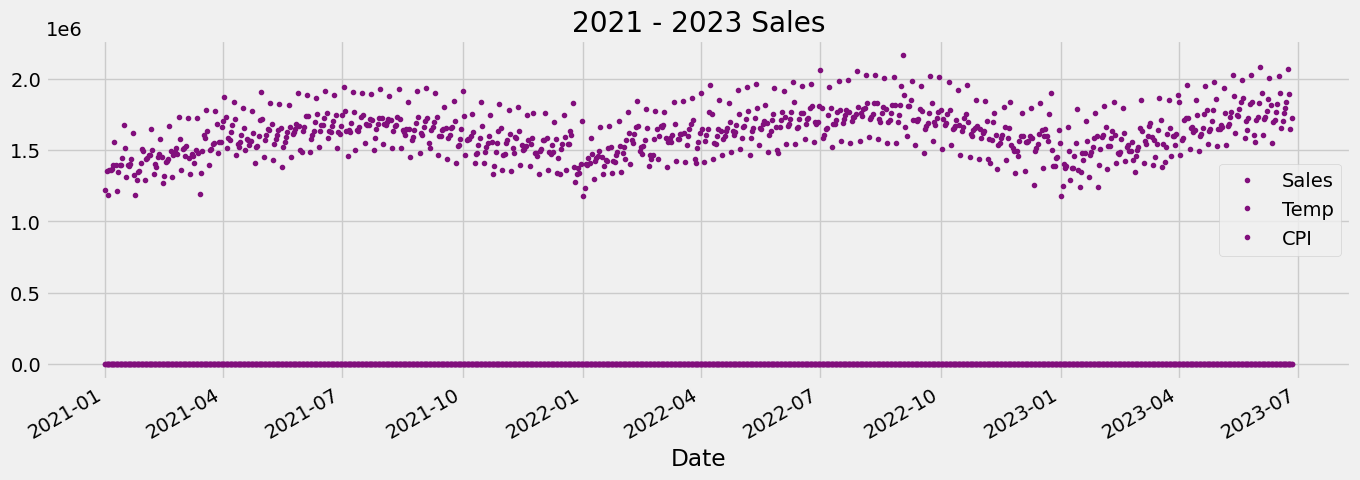

In [ ]:
# Plot the sales data
df.plot(style='.', figsize=(15,5), color=color_pal[5], title='2021 - 2023 Sales')
plt.show()

In [ ]:
# Split the data into training and testing sets based on the date
train = df.loc[df.index < 'Feb 2023']
test = df.loc[df.index >= 'Feb 2023']

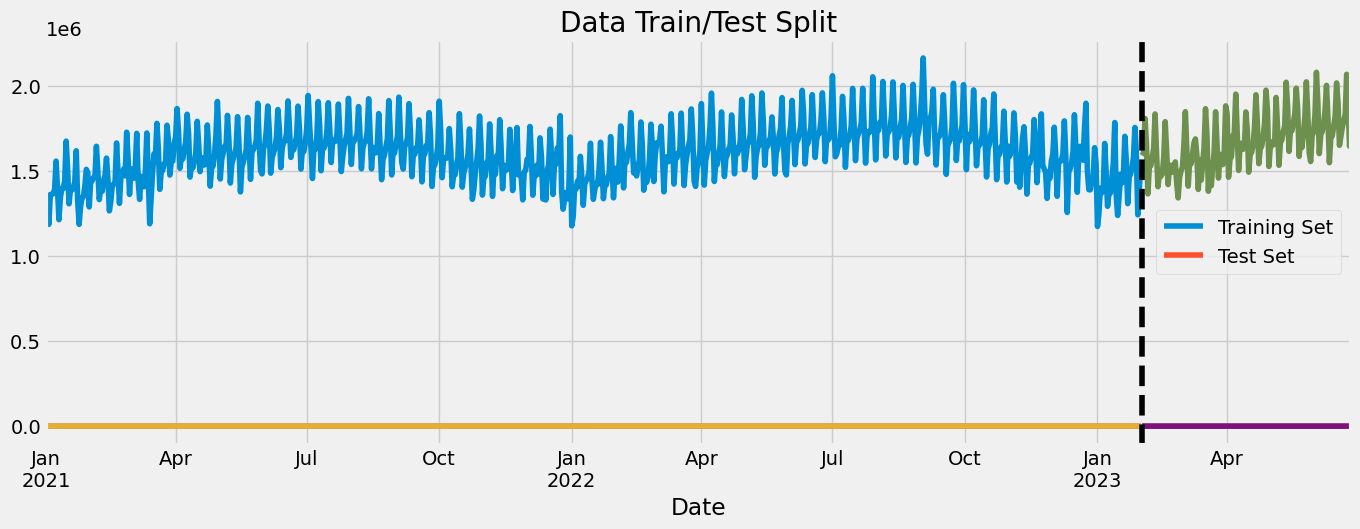

In [ ]:
# Plot the training and testing sets
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Testing Set')
ax.axvline('Feb 2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
def create_features(df):
    """
    Create time series features based on the time series index.
    Add a feature indicating the 3rd, 17th, and 24th day of the month have the highest sales.
    """
    df = df.copy()
    df['dayofweek'] = df.index.day_of_week

    # Add a feature indicating sales are 35% higher on Fridays
    df['friday_sales_increase'] = np.where(df['dayofweek'] == 4, df['Sales'] * 1.25, df['Sales'])

    # Add a feature indicating sales decrease by 20% on Sundays
    df['sunday_sales_decrease'] = np.where(df['dayofweek'] == 6, df['Sales'] * 0.75, df['Sales'])


    return df

In [ ]:
# Create additional features in the training and testing sets
train = create_features(train)
test = create_features(test)

In [ ]:
# Define the features and target variable
FEATURES = ['dayofweek', 'friday_sales_increase', 'sunday_sales_decrease']
TARGET = 'Sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
# Create an XGBoost regression model
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

In [ ]:
# Fit the model on the training data and evaluate on the testing data
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:1599789.04193	validation_1-rmse:1666211.41073
[1]	validation_0-rmse:1583892.21616	validation_1-rmse:1649965.78266
[2]	validation_0-rmse:1568152.75617	validation_1-rmse:1633841.32923
[3]	validation_0-rmse:1552573.16835	validation_1-rmse:1617916.82219
[4]	validation_0-rmse:1537146.01163	validation_1-rmse:1602131.79094
[5]	validation_0-rmse:1521872.90185	validation_1-rmse:1586505.86083
[6]	validation_0-rmse:1506754.29858	validation_1-rmse:1570911.02983
[7]	validation_0-rmse:1491784.61269	validation_1-rmse:1555577.78870
[8]	validation_0-rmse:1476965.57670	validation_1-rmse:1540328.83609
[9]	validation_0-rmse:1462292.23253	validation_1-rmse:1525294.50860
[10]	validation_0-rmse:1447766.06898	validation_1-rmse:1510369.17953
[11]	validation_0-rmse:1433383.84103	validation_1-rmse:1495637.83851
[12]	validation_0-rmse:1419145.08861	validation_1-rmse:1481007.97820
[13]	validation_0-rmse:1405048.09420	validation_1-rmse:1466586.41245
[14]	validation_0-rmse:1391091.46417	validat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Forecast on the testing set
test['prediction'] = reg.predict(X_test)

In [ ]:
# Merge the predictions with the original dataframe
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

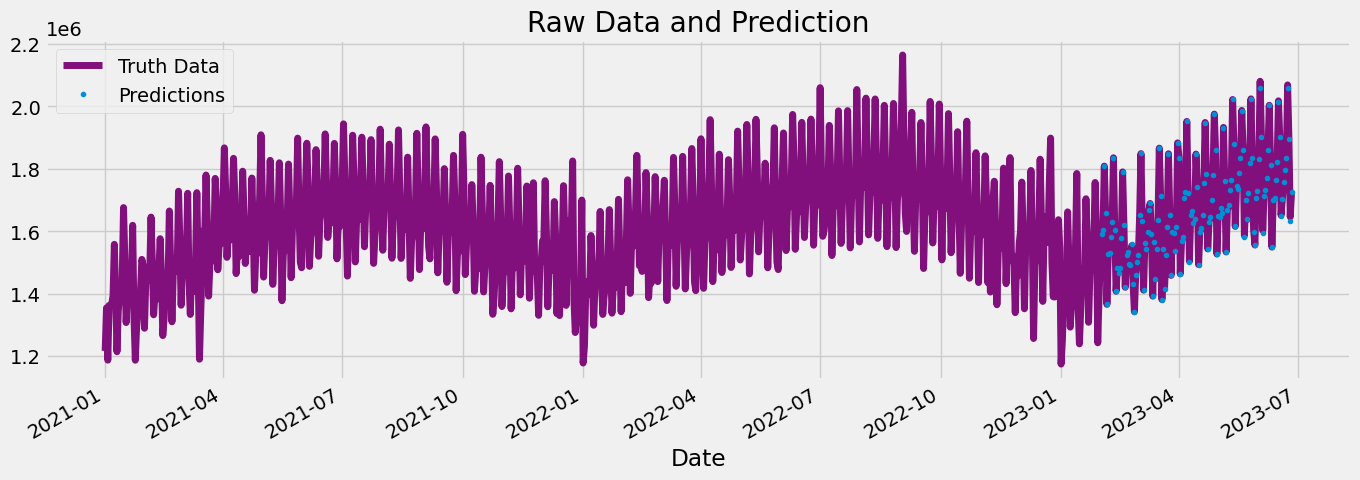

In [ ]:
# Plot the actual sales and predicted values
ax = df[['Sales']].plot(figsize=(15,5),
                        color=color_pal[5],
                               ms=5,
                               lw=5,)
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
# Calculate and print the RMSE score on the testing set
score = np.sqrt(mean_squared_error(test['Sales'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2677.61


In [ ]:
score = mean_absolute_percentage_error(test['Sales'], test['prediction'])
print(f' MAPE Score on Test set: {score:0.2%}')

 MAPE Score on Test set: 0.05%


In [ ]:
# Calculate the error and analyze the best and worst predicted days
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
worst_predicted_days = test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)
best_predicted_days = test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

def add_lags(df):
    target_map = df['Sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('546 days')).map(target_map)
    return df

df = add_lags(df)